In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use("seaborn-v0_8-bright") # notebook, paper, poster @ Desk
plt.style.use("default") # notebook, paper, poster
%matplotlib inline
from matplotlib import ticker
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

# Maps
import pickle
import geopandas as gpd

# Data
# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
#water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
#air = air.dropna(how='any')

# Folder to Save Images (# Laptop @ J: ##### Desktop @ J:)
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')

# Function for NaN Summary
def nan_count(df):
    ##Check the counts of NaNs in each column
    nan_counts = df.isnull().sum()
    # Calculate the percentage of NaNs in each column
    nan_percentage = (df.isnull().sum() / len(df)) * 100
    # Create a summary DataFrame to display the results
    summary_df= pd.DataFrame({'NaN Counts': nan_counts, 'NaN Percentage': nan_percentage})
    # Display the summary DataFrame in a pretty manner
    styled_summary_df = summary_df.style.bar(subset=['NaN Counts'], 
                                                     color='lightcoral') \
    .format({'NaN Percentage': '{:.2f}%'})
    # Show the styled summary DataFrame
    return styled_summary_df

# Create a boolean DataFrame where True indicates NaN values
#nan_locations = air_interpolated.isna()

# Use 'idxmax()' to find the first occurrence of True (NaN) along each column
# This will give you the row index where the first NaN occurs in each column
#first_nan_locations = nan_locations.idxmax()

# You can then access the specific location by getting the row index and column name
#row_index = first_nan_locations['t_adcp_a']
#column_name = 't_adcp_a'

#print(f"The first NaN value in column '{column_name}' occurs at row index {row_index}.")

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


# Remove Anomalies

In [2]:
# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1200]
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -11]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_co2_w, 
                             water_anomalies_ico2_w, 
                             water_anomalies_ch4_w], axis=0)

air_anomalies = pd.concat([air_anomalies_ico2_a, 
                           air_anomalies_co2_a1, 
                           air_anomalies_co2_a2,
                           air_anomalies_ch4_a], axis=0)

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
water = water[~water.index.isin(water_anomalies_ch4_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]
air = air[~air.index.isin(air_anomalies_ch4_a.index)]

### Resample at 30 Minute via Groupby

In [3]:
# Resample to Hourly
water_ = water.groupby(pd.Grouper(key='date_time', axis=0, freq='30T', sort=True)).mean()
# Sort the DataFrame
water_ = water_.sort_index()
# Check NaNs
nan_count(water_)

,NaN Counts,NaN Percentage
ch4_w,299,31.05%
ich4_w,299,31.05%
co2_w,299,31.05%
ico2_w,299,31.05%
lat_w,304,31.57%
lon_w,304,31.57%
sog_w,304,31.57%
cog_w,304,31.57%
t_air_w,304,31.57%
rh_w,304,31.57%


In [4]:
# Transect I
df1w = water_.loc['2016-07-23 00:00:00':'2016-08-03 23:59:59'].copy()
df2w = water_.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00'].copy()

# Extract the date component from the index (which is 'date_time')
df1w['date'] = df1w.index.date
df2w['date'] = df2w.index.date

# Group the data by each day
group_1 = df1w.groupby('date')
group_2 = df2w.groupby('date')

# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_1 = {str(day): group for day, group in group_1}
daily_data_dict_2 = {str(day): group for day, group in group_2}

In [5]:
# Resample to Hourly
air_ = air.groupby(pd.Grouper(key='date_time', axis=0, freq='30T', sort=True)).mean()
# Sort the DataFrame
air_ = air_.sort_index()

# Transect I
df1a = air_.loc['2016-07-23 00:00:00':'2016-08-03 23:59:59'].copy()
df2a = air_.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00'].copy()

# Extract the date component from the index (which is 'date_time')
df1a['date'] = df1a.index.date
df2a['date'] = df2a.index.date

# Group the data by each day
group_1a = df1a.groupby('date')
group_2a = df2a.groupby('date')

# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_1a = {str(day): group for day, group in group_1a}
daily_data_dict_2a = {str(day): group for day, group in group_2a}

In [6]:
# Calculate the number of subplots needed
num_subplots_1 = len(group_1)
# Calculate the number of rows for the subplot grid and Round up the division result to the nearest integer
num_rows_1 = (num_subplots_1 + 4) // 4 
# Calculate the number of columns for the subplot grid
num_cols_1 = min(num_subplots_1, 3)

# Calculate the number of subplots needed
num_subplots_2 = len(group_2)
# Calculate the number of rows for the subplot grid and Round up the division result to the nearest integer
num_rows_2 = (num_subplots_2 + 4) // 4 
# Calculate the number of columns for the subplot grid
num_cols_2 = min(num_subplots_2, 3)

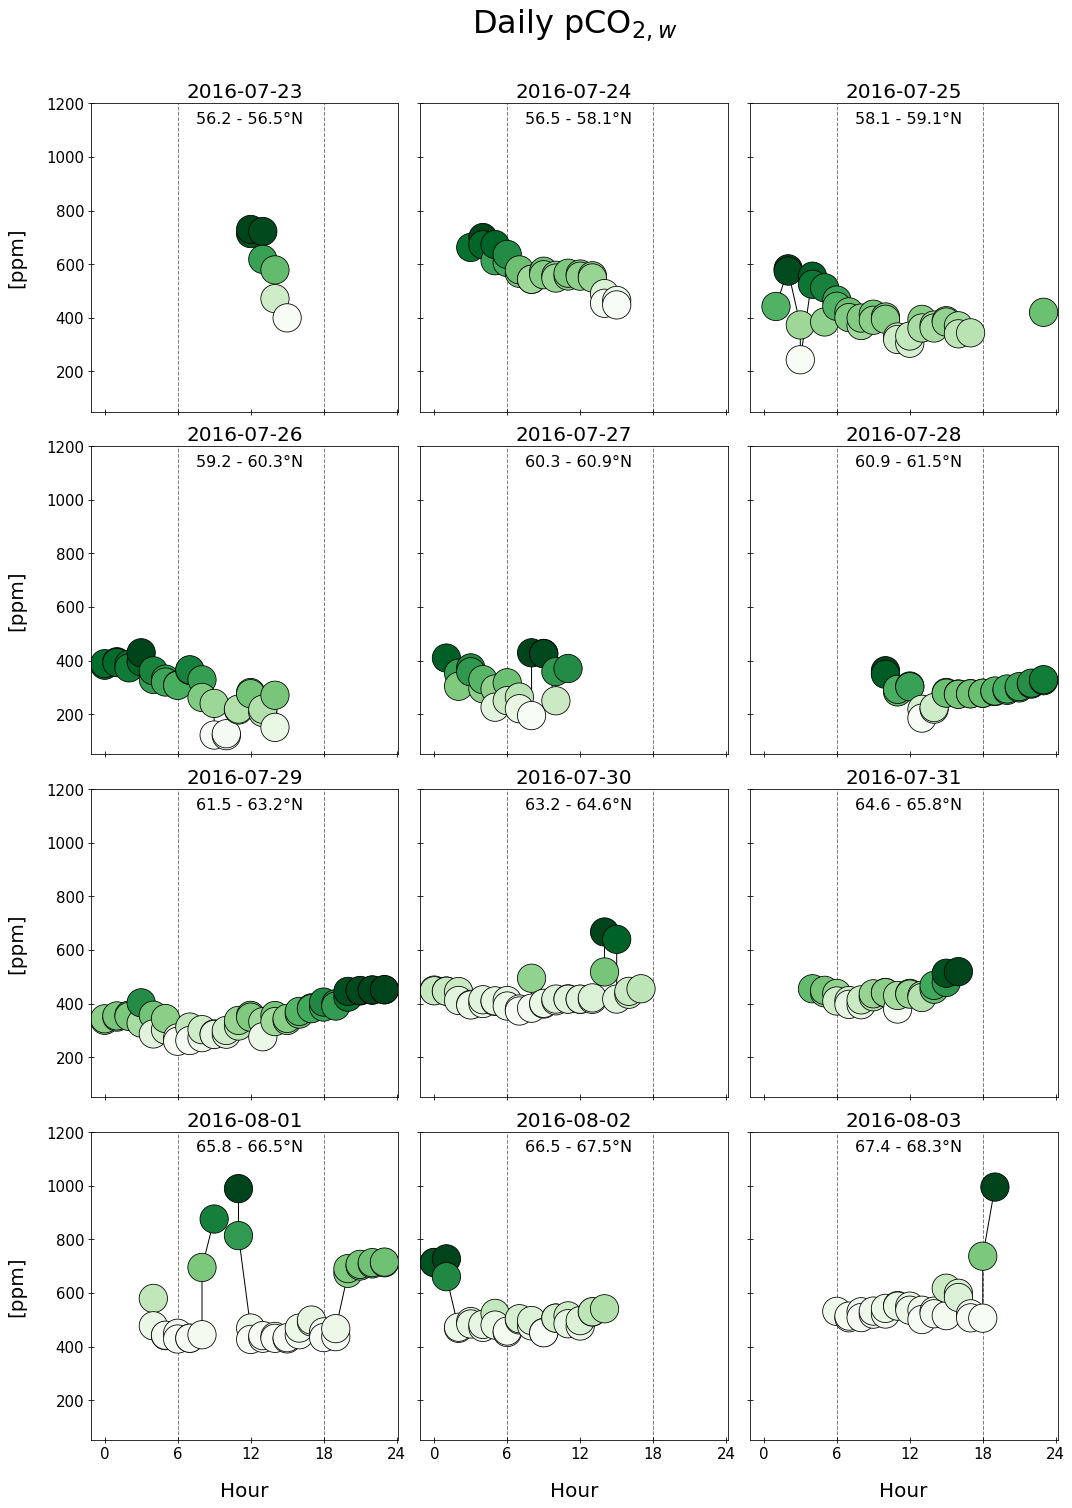

In [7]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows_1, num_cols_1, figsize=(15, 5*num_rows_1), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows_1 > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots_1 > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], 
               cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=800, edgecolor='black', zorder=2,) #vmin = group['co2_w'].quantile(0.05), vmax = group['co2_w'].quantile(0.95), 
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols_1 == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols_1 * (num_rows_1 - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(50, 1200)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots_1 < len(axs):
    for j in range(num_subplots_1, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2,w}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

fig.savefig('Chomiak_Daily_30min_co2w_I.png', dpi = 600, bbox_inches='tight')

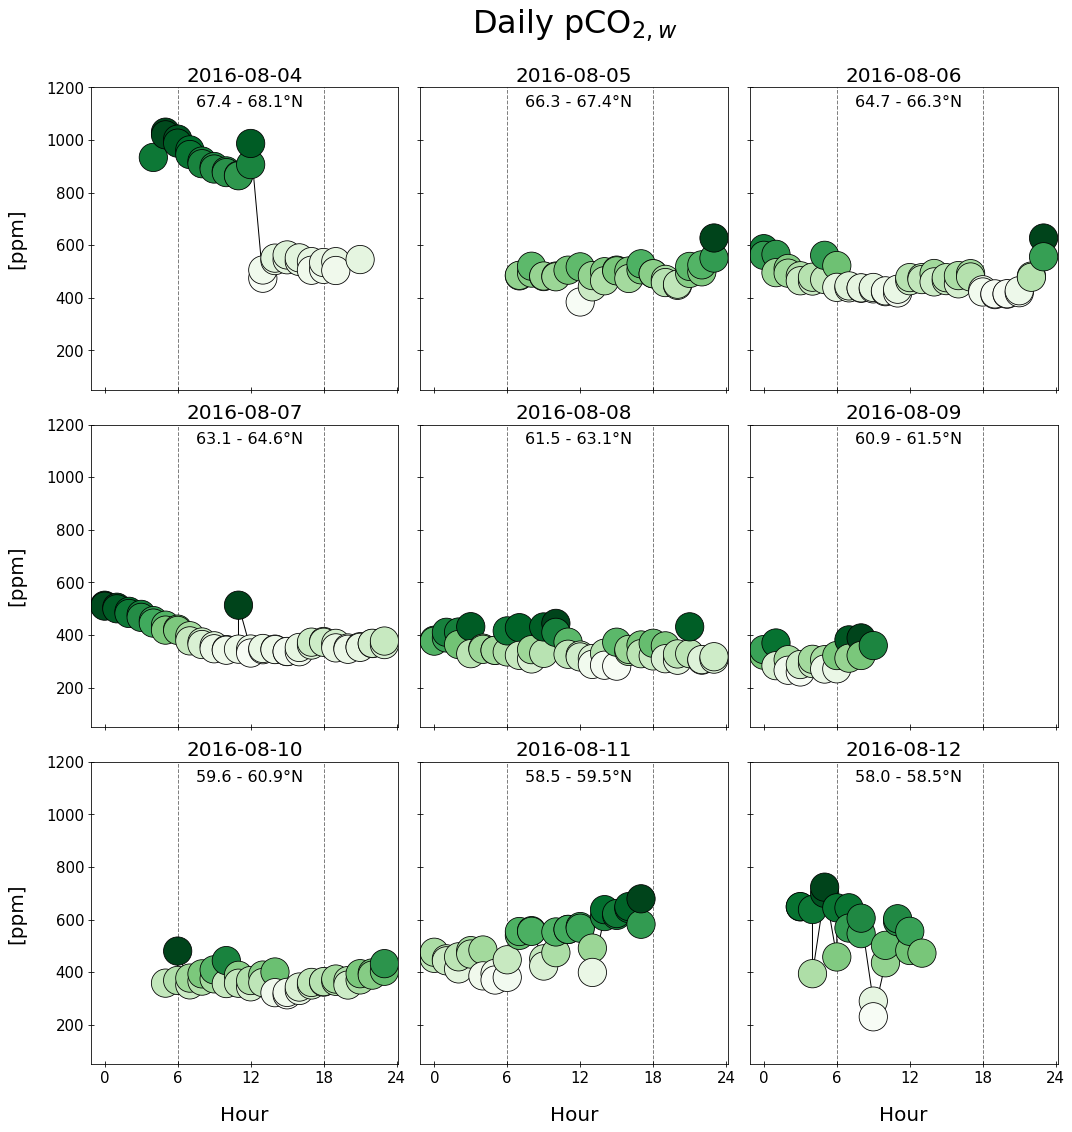

In [8]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows_2, num_cols_2, figsize=(15, 5*num_rows_2), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows_2 > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_2):
    ax = axs[i] if num_subplots_2 > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['co2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['co2_w'], 
               cmap = 'Greens', c = group['co2_w'],
               lw=0.8, s=800, edgecolor='black', zorder=2,) #vmin = group['co2_w'].quantile(0.05), vmax = group['co2_w'].quantile(0.95), 
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols_2 == 0:
        ax.set_ylabel('[ppm]', color='black', fontsize=20, labelpad=20)
    # Iterate Labels per Bottom Column
    if i >= num_cols_2 * (num_rows_2 - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(50, 1200)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots_2 < len(axs):
    for j in range(num_subplots_2, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily pCO$_{2,w}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

fig.savefig('Chomiak_Daily_30min_co2w_II.png', dpi = 600, bbox_inches='tight')

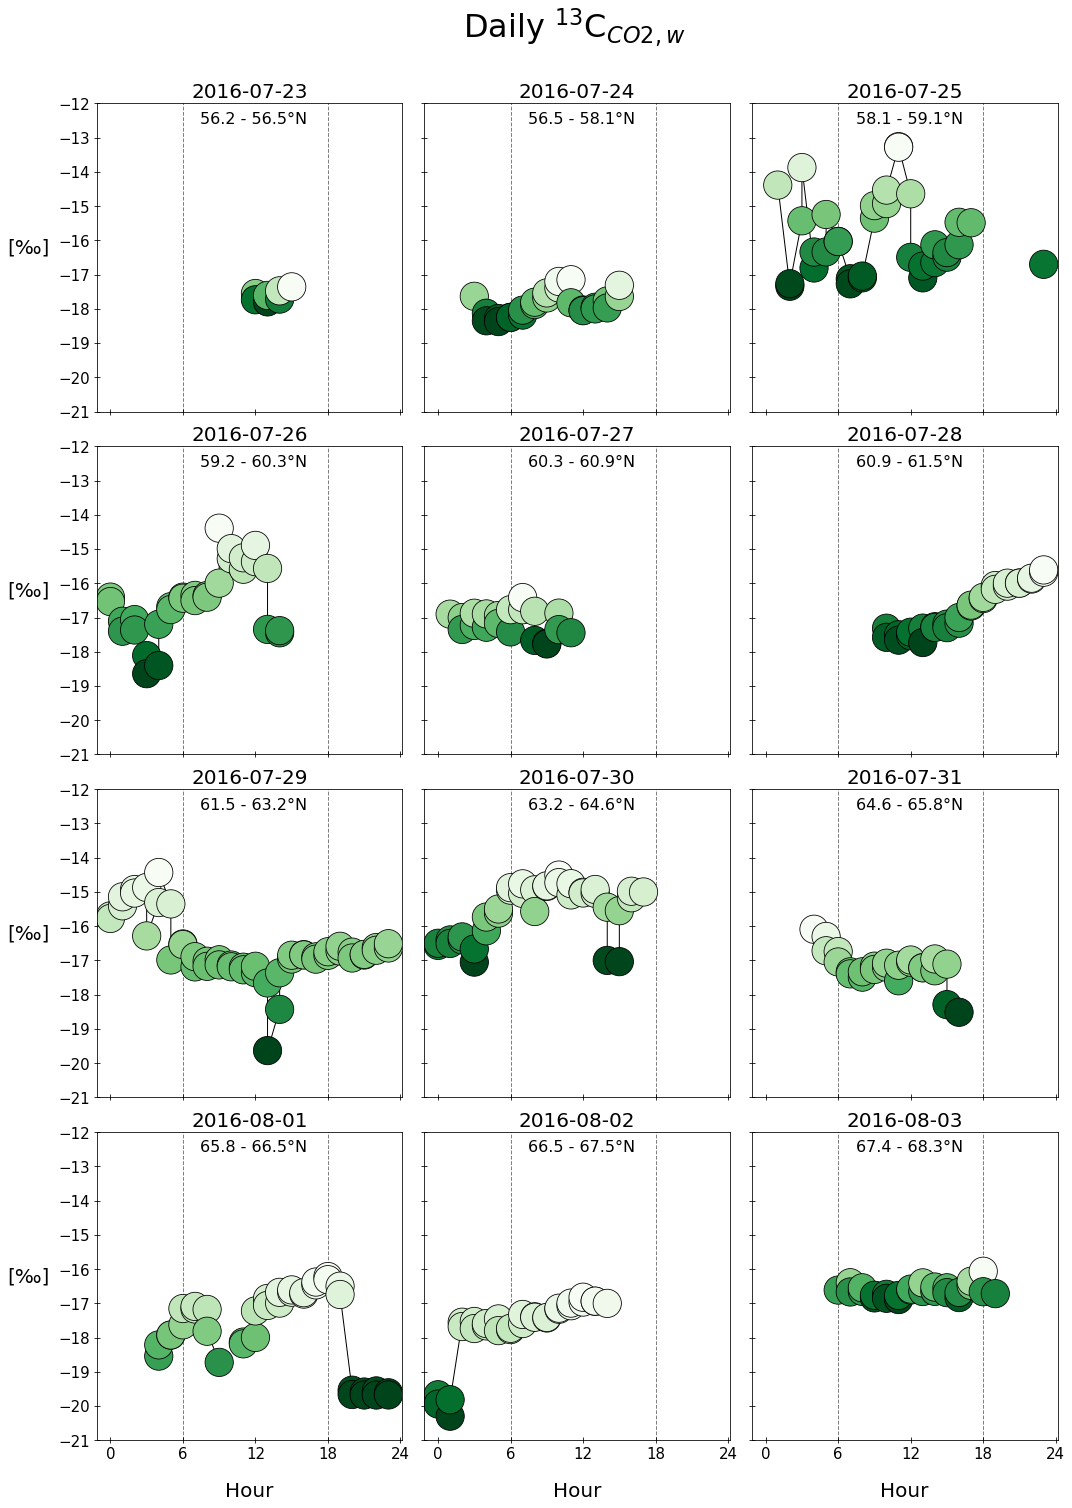

In [9]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows_1, num_cols_1, figsize=(15, 5*num_rows_1), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows_1 > 1:
    axs = axs.flatten()

# Iterate over the group_1 and create subplots
for i, (day, group) in enumerate(group_1):
    ax = axs[i] if num_subplots_1 > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['ico2_w'], c='black', lw=1, zorder=1)  # Replace 'your_column' with the actual column name
    ax.scatter(group['hour'], group['ico2_w'], 
               cmap = 'Greens_r', c = group['ico2_w'], 
               lw=0.8, s=800, edgecolor='black', zorder=2,) # #vmin = group['ico2_w'].quantile(0.05), vmax = group['ico2_w'].quantile(0.95),
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols_1 == 0:
        ax.set_ylabel('[‰]', color='black', fontsize=20, labelpad=30, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols_1 * (num_rows_1 - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(-21, -12)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots_1 < len(axs):
    for j in range(num_subplots_1, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily $^{13}$C$_{CO2,w}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

fig.savefig('Chomiak_Daily_30min_ico2w_I_total.png', dpi = 600, bbox_inches='tight')

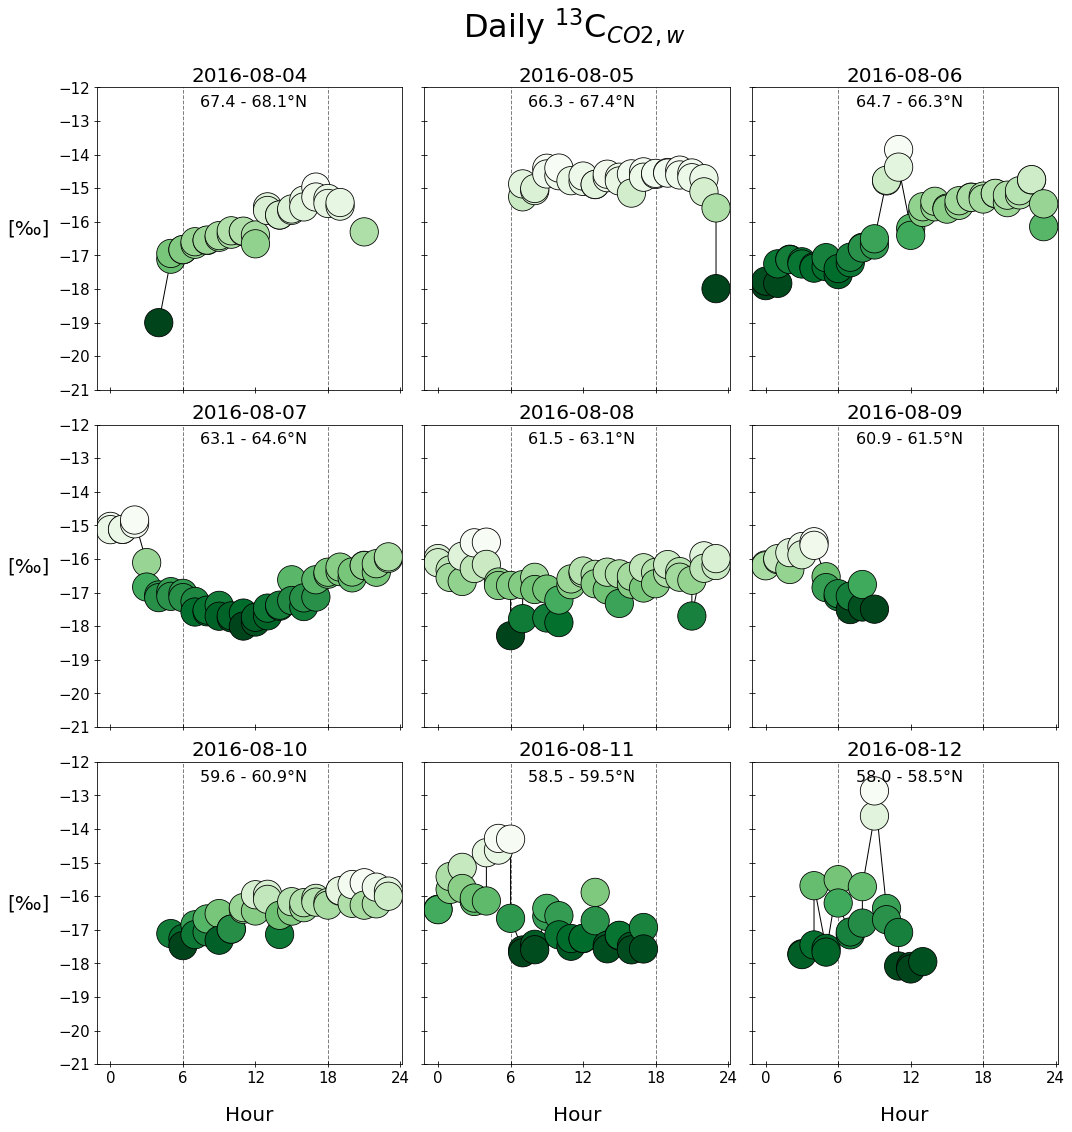

In [10]:
# Create subplots with a grid layout
fig, axs = plt.subplots(num_rows_2, num_cols_2, figsize=(15, 5*num_rows_2), sharex=True, sharey=True)

# Flatten the axs array if it has multiple rows
if num_rows_2 > 1:
    axs = axs.flatten()

# Iterate over the group_2 and create subplots
for i, (day, group) in enumerate(group_2):
    ax = axs[i] if num_subplots_2 > 1 else axs  # Access the appropriate subplot
    ax.plot(group['hour'], group['ico2_w'], c='black', lw=1, zorder=1)
    ax.scatter(group['hour'], group['ico2_w'], 
               cmap = 'Greens_r', c = group['ico2_w'],
               lw=0.8, s=800, edgecolor='black', zorder=2,) #vmin = group['ico2_w'].quantile(0.05), vmax = group['ico2_w'].quantile(0.95), 
    # Set the subplot title as the day
    ax.set_title(day, fontsize=20, c='black')
    # Iterate Labels per Row
    if i % num_cols_2 == 0:
        ax.set_ylabel('[‰]', color='black', fontsize=20, labelpad=30, rotation=0)
    # Iterate Labels per Bottom Column
    if i >= num_cols_2 * (num_rows_2 - 1):
        ax.set_xlabel('Hour', color='black', fontsize=20, labelpad=20)

    # Set the x-axis ticks and labels to represent hours of the day
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    ax.yaxis.set_tick_params(direction='inout', length=6, labelsize=15)
    # Set limits
    ax.set_ylim(-21, -12)
    # High-Noon
    ax.axvline(6, color='grey', ls='--', lw=1, zorder=0)
    ax.axvline(18, color='grey', ls='--', lw=1, zorder=0)
    # Calculate the minimum and maximum values of the 'lat_w' column in the current group
    lat_min, lat_max = group['lat_w'].min(), group['lat_w'].max()
    # Display the minimum and maximum values as text at the top center of the subplot
    ax.text(0.515, 0.95, f'{lat_min:.1f} - {lat_max:.1f}\u00B0N', fontsize=16, transform=ax.transAxes, ha='center', va='center')
    #ax.set_title(f'{formatted_date} ({lat_min:.1f} - {lat_max:.1f}\u00B0N)', fontsize=18, c='black')  # Set the subplot title as the formatted date   
    
# Remove any unused subplots
if num_subplots_2 < len(axs):
    for j in range(num_subplots_2, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.suptitle('Daily $^{13}$C$_{CO2,w}$', fontsize=32, c='black', x=0.535, y=1.045)
plt.show()

fig.savefig('Chomiak_Daily_30min_ico2w_II.png', dpi = 600, bbox_inches='tight')

# Daily Ranges

In [11]:
#from mpl_toolkits.mplot3d import Axes3D
# Sample data - replace these with your actual data
#hours = [hour_data]       # array of hours
#latitudes = [lat_w_data]  # array of latitudes
#co2_concentrations = [co2_w_data]  # array of CO2 concentrations

#hours = df1w['hour'].values      # array of hours
#latitudes = df1w['lat_w'].values  # array of latitudes
#co2_concentrations = df1w['co2_w'].values  # array of CO2 concentrations


# Create a 3D subplot
#fig = plt.figure(figsize=(10, 7))
#ax = fig.add_subplot(111, projection='3d')

# Scatter plot
#ax.scatter(hours, latitudes, co2_concentrations, cmap='magma', c=co2_concentrations, s=100)

# Setting labels
#ax.set_xlabel('Hour')
#ax.set_ylabel('Latitude')
#ax.set_zlabel('CO2 Concentration')

<br><br><br>

### Dictionary of Days and Watersheds

<br><br><br>

In [12]:
# Krasnoyarsk (Downstream)
krasno_1a = daily_data_dict_1['2016-07-23']
krasno_1b = daily_data_dict_1['2016-07-24']

# Angara (Downstream)
angara_1a = daily_data_dict_1['2016-07-25']
angara_1b = daily_data_dict_1['2016-07-26']
angara_1c = daily_data_dict_1['2016-07-27']
angara_1d = daily_data_dict_1['2016-07-28']
combined_angara_1 = pd.concat([angara_1a, angara_1b, angara_1c, angara_1d])
#combined_angara_1 = df1w[(df1w['date'] >= datetime.date(2016, 7, 25)) & (df1w['date'] <= datetime.date(2016, 7, 28))]
combined_angara_krasno_1 = pd.concat([angara_1a, angara_1b, angara_1c, angara_1d, krasno_1a, krasno_1b])

# Angara (Upstream)
angara_2a = daily_data_dict_2['2016-08-12']


#PT
pt_1a = daily_data_dict_1['2016-07-29']
pt_1b = daily_data_dict_1['2016-07-30']
combined_pt_1 = pd.concat([pt_1a, pt_1b])
#combined_pt_1 = df1w[(df1w['date'] == datetime.date(2016, 7, 29)) & (df1w['date'] == datetime.date(2016, 8, 8))]

# NT
nt_0 = daily_data_dict_1['2016-07-31']
nt_1 = daily_data_dict_1['2016-08-01']
combined_nt_1 = pd.concat([nt_0, nt_1])

# Igarka
igarka_1 = daily_data_dict_1['2016-08-03']

# Downstream
krasno_2a = daily_data_dict_2['2016-08-12']
angara_2b = daily_data_dict_2['2016-08-11']
pt_2 = daily_data_dict_2['2016-08-08']
nt_2 = daily_data_dict_2['2016-08-06']
igarka_2 = daily_data_dict_2['2016-08-04']

# Combined
combined_igarka = pd.concat([igarka_1, igarka_2])
combined_nt_1 = pd.concat([nt_0, nt_1, nt_2])
combined_krasno_1 = pd.concat([krasno_1a, krasno_1b])

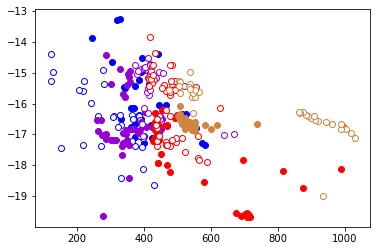

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
# Angara
ax.scatter(angara_1a['co2_w'], angara_1a['ico2_w'], c='blue', ec='blue')
ax.scatter(angara_1b['co2_w'], angara_1b['ico2_w'], c='white', ec='blue')
# PT
ax.scatter(pt_1a['co2_w'], pt_1a['ico2_w'], c='darkviolet', ec='darkviolet')
ax.scatter(pt_1b['co2_w'], pt_1b['ico2_w'], c='white', ec='darkviolet')
# NT
ax.scatter(nt_1['co2_w'], nt_1['ico2_w'], c='red', ec='red')
ax.scatter(nt_2['co2_w'], nt_2['ico2_w'], c='white', ec='red')
# Igarka
ax.scatter(igarka_1['co2_w'], igarka_1['ico2_w'], c='peru', ec='peru')
ax.scatter(igarka_2['co2_w'], igarka_2['ico2_w'], c='white', ec='peru')

### Import Map Packages and Main Shapefiles

In [14]:
import pickle
import geopandas as gpd
# Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')
# Yenisey Watershed
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

# Import Watershed Shapefiles and Riverlines, and isolate main tributaries (Angara, P_Tunguska, and N_Tunguska) and their regions of confluence.

# Open the dictionary with pickle
with open('watersheds_gdfs.pkl', 'rb') as file:
    watersheds_gdfs = pickle.load(file)
print("Dictionary loaded successfully.")

angara = watersheds_gdfs['w_3227']
pt = watersheds_gdfs['w_3224']
nt = watersheds_gdfs['w_3222']

krasno = watersheds_gdfs['w_3226']
angara_confluence = watersheds_gdfs['w_3225']
pt_confluence = watersheds_gdfs['w_3223']
nt_confluence = watersheds_gdfs['w_3221']

# Import Watershed River Lines and isolate main tributaries (Angara, P_Tunguska, and N_Tunguska) and their regions of confluence.

# Open the Pickle (rb = read-binary)
with open('clipped_rivers_by_watershed.pkl', 'rb') as file:
    # Load the dictionary from the file
    clipped_rivers_by_watershed = pickle.load(file)
print("Dictionary loaded successfully.")

rangara = clipped_rivers_by_watershed['w_3227']
rpt = clipped_rivers_by_watershed['w_3224']
rnt = clipped_rivers_by_watershed['w_3222']

rkrasno = clipped_rivers_by_watershed['w_3226']
rangara_confluence = clipped_rivers_by_watershed['w_3225']
rpt_confluence = clipped_rivers_by_watershed['w_3223']
rnt_confluence = clipped_rivers_by_watershed['w_3221']

# Color Coordinate for Watersheds
colors = ['darkblue', 'darkviolet', 'darkgreen', 'violet', 'maroon', 'orange', 'peru', 'forestgreen', 'red', 'darkgrey', 
          'lightgrey', 'grey', 'peru', 'sandybrown', 'darkgoldenrod', 'goldenrod', 'palegoldenrod', 'tan', 'navajowhite', 'floralwhite']

PFAF_ID_4d = ['3227', '3222', '3226', '3224', '3221', '3229', '3228', '3225', '3223', '3422', 
              '3429', '3316', '3610', '3428', '3124', '3312', '3136', '3210', '3427', '3230']

color_dict = {pfaf_id: color for pfaf_id, color in zip(PFAF_ID_4d, colors)}

# Colormap
watershed_colors = {}

for watershed_name in clipped_rivers_by_watershed.keys():
    # Extracting the PFAF_ID_4d from the key by stripping the "w_" prefix
    pfaf_id = watershed_name.split("_")[1]
    
    # Getting the color for this PFAF_ID_4d
    watershed_color = color_dict[pfaf_id]
    
    # Storing the color in the new dictionary
    watershed_colors[watershed_name] = watershed_color
    
# Normalize CRS
#gdf_lakes = gdf_lakes.to_crs(nt_confluence.crs)

# Perform spatial join - this joins lakes to watersheds they fall within
krasno_lakes = gpd.sjoin(gpd_lakes, krasno, how='inner', op='within')
angara_lakes = gpd.sjoin(gpd_lakes, angara, how='inner', op='within')
nt_lakes = gpd.sjoin(gpd_lakes, nt, how='inner', op='within')
nt_confluence_lakes = gpd.sjoin(gpd_lakes, nt_confluence, how='inner', op='within')

#pt_lakes = gpd.sjoin(gpd_lakes, pt, how='inner', op='within')
#angara_confluence_lakes = gpd.sjoin(gpd_lakes, angara_confluence, how='inner', op='within')
#pt_confluence_lakes = gpd.sjoin(gpd_lakes, pt_confluence, how='inner', op='within')

# Import Siberian Markers (Amon_2016_Yenisei)
markers = 'Siberian_Markers_1.txt'
markers = pd.read_csv(markers, delim_whitespace=True, skiprows=0)
markers.columns = markers.columns.str.strip()
markers.index = markers.Name
# Mains
stations = markers.loc[['Dudinka','Igarka']]
tribs = markers.loc[['Angara','Bratsk','P_Tunguska','N_Tunguska']]
hydropower = markers.loc[['Sayano_Shushenskaya','Bratsk','Krasnoyarskh','Ust_Ilimsk', 'Boguchany']]

Dictionary loaded successfully.
Dictionary loaded successfully.


### All

In [15]:
#for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
#    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
#    if subset.empty:  # Check if the subset is empty
#        continue  # Skip the current iteration if it is empty
##    
#    # Define line width and z-order based on river order
#    if flow_order == 1:
#        lw, z = 6, 7
#    elif flow_order == 2:
#        lw, z = 6, 6
#    elif flow_order == 3:
#        lw, z = 4, 5
#    elif flow_order == 4:
#        lw, z = 2, 4
#    elif flow_order == 5:
#        lw, z = 1, 3
#    elif flow_order == 6:
#        lw, z = 0.5, 2
    
#    # Plot the rivers
#    subset.plot(ax=ax, color='silver', lw=lw, zorder=z)

(46.37338787934154, 71.62704695372541)

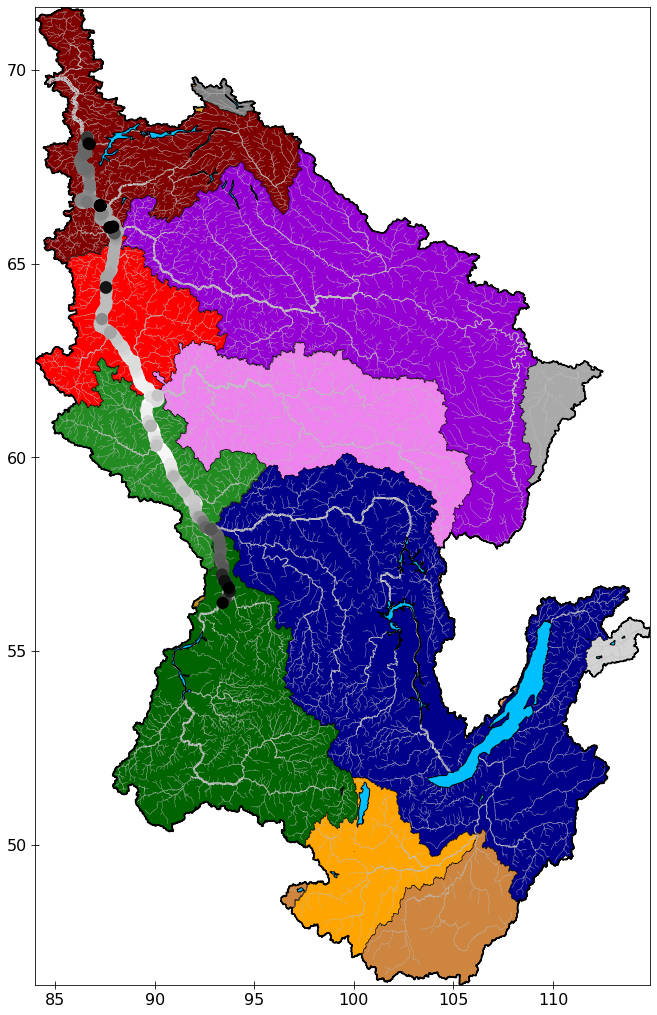

In [16]:
df1w = df1w.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

# First, plot the watersheds using the color from color_dict
for watershed_name, watershed_gdf in watersheds_gdfs.items():
    pfaf_value = watershed_name.split("_")[1]
    watershed_color = color_dict[pfaf_value]
    watershed_gdf.plot(ax=ax, color=watershed_color, edgecolor='black', lw=0.5, zorder=1)
    
# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 4, 6
        elif flow_order == 3:
            lw, z = 2, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.5, 3
        elif flow_order == 6:
            lw, z = 0.333, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='silver', lw=lw, zorder=z)
    
# Scatters
m1 = ax.scatter(df1w['lon_w'], df1w['lat_w'], 
                c=df1w['co2_w'], cmap='Greys',vmin=df1w['co2_w'].quantile(0.05), vmax=df1w['co2_w'].quantile(0.95), 
                marker='o', s=150, linewidth=1, edgecolor='none', zorder=9) #vmin=df1w['co2_w'].quantile(0.05), vmax=df1w['co2_w'].quantile(0.95), 

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

(46.37338787934154, 71.62704695372541)

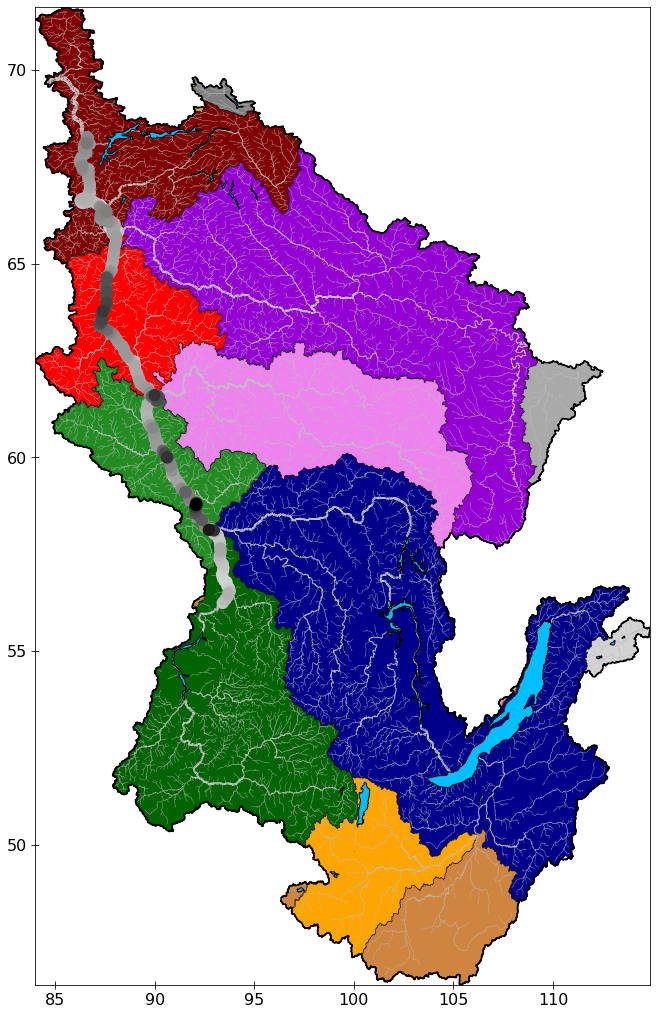

In [17]:
df1w = df1w.sort_values(by='ico2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

# First, plot the watersheds using the color from color_dict
for watershed_name, watershed_gdf in watersheds_gdfs.items():
    pfaf_value = watershed_name.split("_")[1]
    watershed_color = color_dict[pfaf_value]
    watershed_gdf.plot(ax=ax, color=watershed_color, edgecolor='black', lw=0.5, zorder=1)
    
# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 4, 6
        elif flow_order == 3:
            lw, z = 2, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.5, 3
        elif flow_order == 6:
            lw, z = 0.333, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='silver', lw=lw, zorder=z)
    
# Scatters
m1 = ax.scatter(df1w['lon_w'], df1w['lat_w'], 
                c=df1w['ico2_w'], cmap='Greys',
                marker='o', s=150, linewidth=1, edgecolor='none', zorder=9) #vmin=df1w['ico2_w'].quantile(0.05), vmax=df1w['ico2_w'].quantile(0.95), 

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [18]:
# Calculate global color limits for the colormap
co2_min = water_['co2_w'].min()
co2_max = water_['co2_w'].max()

# Calculate global color limits for the colormap
global_co2_min = water_['co2_w'].quantile(0.05)
global_co2_max = water_['co2_w'].quantile(0.95)

print(co2_min)
print(global_co2_min)
print()
print(co2_max)
print(global_co2_max)

120.05409561333333
276.15390047838895

1029.8242472666666
705.7671219908335


In [19]:
# Calculate global color limits for the colormap
ico2_min = water_['ico2_w'].min()
ico2_max = water_['ico2_w'].max()

# Calculate global color limits for the colormap
global_ico2_min = water_['ico2_w'].quantile(0.05)
global_ico2_max = water_['ico2_w'].quantile(0.95)

print(ico2_min)
print(global_ico2_min)
print()
print(ico2_max)
print(global_ico2_max)

-20.29652333
-18.108602479276666

-12.864144119333332
-14.686314238676923


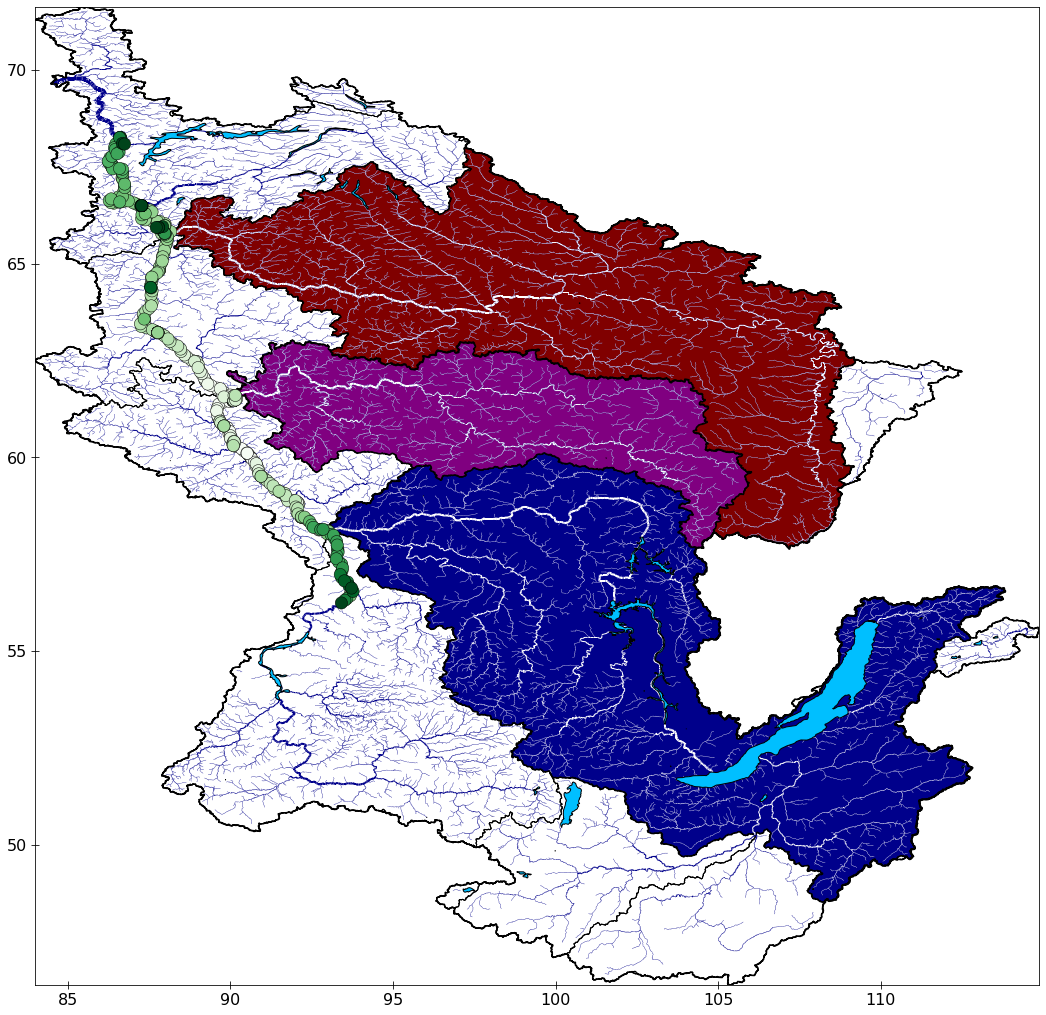

In [22]:
df1w = df1w.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

# First, plot the watersheds using the color from color_dict
for watershed_name, watershed_gdf in watersheds_gdfs.items():
    pfaf_value = watershed_name.split("_")[1]
    watershed_color = color_dict[pfaf_value]
    watershed_gdf.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=1)
    
# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 4, 6
        elif flow_order == 3:
            lw, z = 2, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.5, 3
        elif flow_order == 6:
            lw, z = 0.333, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
        
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt[rpt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt[rnt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara[rangara['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2

    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
# Scatters
m1 = ax.scatter(df1w['lon_w'], df1w['lat_w'], 
                c=df1w['co2_w'], cmap='Greens', vmin=global_co2_min, vmax=global_co2_max,
                marker='o', s=150, linewidth=0.5, edgecolor='black', zorder=9) 

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)

angara.plot(ax=ax, color='darkblue', edgecolor='black', lw=1.5)#, zorder=8
pt.plot(ax=ax, color='purple', edgecolor='black', lw=1.5)
nt.plot(ax=ax, color='maroon', edgecolor='black', lw=1.5)

#angara_confluence.plot(ax=ax, color='blue', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#pt_confluence.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt_confluence.plot(ax=ax, color='red', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)

#angara.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#pt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt.plot(ax=ax, color='darkviolet', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)


#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect('auto')

In [21]:
halt

NameError: name 'halt' is not defined

In [ ]:
df1w = df1w.sort_values(by='ico2_w', ascending=False)

fig, ax = plt.subplots(figsize=(18, 18))

# First, plot the watersheds using the color from color_dict
for watershed_name, watershed_gdf in watersheds_gdfs.items():
    pfaf_value = watershed_name.split("_")[1]
    watershed_color = color_dict[pfaf_value]
    watershed_gdf.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=1)
    
# Now, plot the rivers
for subset_name, rivers_gdf in clipped_rivers_by_watershed.items():
    
    # Fetch the 'PFAF_ID_4d' value from the watershed_name and get the corresponding color
    pfaf_value = subset_name.split("_")[1]
    
    for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
        
        subset = rivers_gdf[rivers_gdf['ORD_FLOW'] == flow_order]
        if subset.empty:  # Check if the subset is empty
            continue  # Skip the current iteration if it is empty
        
        # Define line width and z-order based on river order
        if flow_order == 1:
            lw, z = 6, 7
        elif flow_order == 2:
            lw, z = 4, 6
        elif flow_order == 3:
            lw, z = 2, 5
        elif flow_order == 4:
            lw, z = 1, 4
        elif flow_order == 5:
            lw, z = 0.5, 3
        elif flow_order == 6:
            lw, z = 0.333, 2
        
        # Plot the rivers
        subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
        
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt[rpt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt[rnt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara[rangara['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 4, 6
    elif flow_order == 3:
        lw, z = 2, 5
    elif flow_order == 4:
        lw, z = 1, 4
    elif flow_order == 5:
        lw, z = 0.5, 3
    elif flow_order == 6:
        lw, z = 0.333, 2

    
    # Plot the rivers
    subset.plot(ax=ax, color='white', lw=lw, zorder=z)
    
# Scatters
m1 = ax.scatter(df1w['lon_w'], df1w['lat_w'], 
                c=df1w['ico2_w'], cmap='Greens_r', vmin=global_ico2_min, vmax=global_ico2_max,
                marker='o', s=150, linewidth=0.5, edgecolor='black', zorder=9) 

AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)

angara.plot(ax=ax, color='darkblue', edgecolor='black', lw=1.5)#, zorder=8
pt.plot(ax=ax, color='purple', edgecolor='black', lw=1.5)
nt.plot(ax=ax, color='maroon', edgecolor='black', lw=1.5)

#angara_confluence.plot(ax=ax, color='blue', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#pt_confluence.plot(ax=ax, color='violet', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt_confluence.plot(ax=ax, color='red', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)

#angara.plot(ax=ax, color='deepskyblue', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#pt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt.plot(ax=ax, color='darkviolet', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)


#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_aspect('auto')

<br><br><br>

# Krasnoyarsk/Angara Region

<br>

#### Kan River
#### Lake Baikal
#### Hydropower Stations

<br>

- krano_1a, ax.set_xlim(92, 95), ax.set_ylim(56, 57) <br>
- krasno_1b, ax.set_xlim(92, 95), ax.set_ylim(56, 58.5)
<br><br>

In [ ]:
combined_angara_krasno_1 = combined_angara_krasno_1.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rkrasno[rkrasno['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara[rangara['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(combined_angara_krasno_1['lon_w'], combined_angara_krasno_1['lat_w'], c=combined_angara_krasno_1['co2_w'], cmap='Greens', 
                vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

krasno.plot(ax=ax, color='grey', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)

krasno.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara_confluence.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)

angara_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
krasno_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)

#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
xmina, ymina, xmaxa, ymaxa = angara.total_bounds
xmink, ymink, xmaxk, ymaxk = krasno.total_bounds

ax.set_xlim(xminac, xmaxa)
ax.set_ylim(ymina, ymaxac)

#krasno_hydropower = markers.loc[['Sayano_Shushenskaya', 'Krasnoyarskh']]
#ax.scatter(krasno_hydropower['lon'], krasno_hydropower['lat'], c='yellow', marker='s', s=300, linewidth=1, edgecolor='black', zorder=9)

In [ ]:
combined_angara_1 = combined_angara_1.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rkrasno[rkrasno['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara[rangara['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(combined_angara_1['lon_w'], combined_angara_1['lat_w'], c=combined_angara_1['co2_w'], cmap='Greens', 
                vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

krasno.plot(ax=ax, color='grey', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)

krasno.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara_confluence.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)

angara_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
krasno_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)

#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
xmina, ymina, xmaxa, ymaxa = angara.total_bounds
xmink, ymink, xmaxk, ymaxk = krasno.total_bounds

ax.set_xlim(xminac, xmaxac)
ax.set_ylim(yminac, ymaxac)

#krasno_hydropower = markers.loc[['Sayano_Shushenskaya', 'Krasnoyarskh']]
#ax.scatter(krasno_hydropower['lon'], krasno_hydropower['lat'], c='yellow', marker='s', s=300, linewidth=1, edgecolor='black', zorder=9)

In [ ]:
combined_angara_1 = combined_angara_1.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rkrasno[rkrasno['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara[rangara['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(combined_angara_1['lon_w'], combined_angara_1['lat_w'], c=combined_angara_1['co2_w'], cmap='Greens', 
                vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

krasno.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara.plot(ax=ax, color='grey', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)

krasno.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)
angara_confluence.boundary.plot(ax=ax, color='black', edgecolor='black', lw=1.5, zorder=9)

angara_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
krasno_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)

#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
xmina, ymina, xmaxa, ymaxa = angara.total_bounds
xmink, ymink, xmaxk, ymaxk = krasno.total_bounds

ax.set_xlim(xminac, 93)
ax.set_ylim(58.5, 61.5)

<br><br><br>

### P Tunguska

<br><br><br>

In [ ]:
pt_1a = daily_data_dict_1['2016-07-29']
pt_1b = daily_data_dict_1['2016-07-30']
pt_1c = daily_data_dict_1['2016-07-31']
combined_pt_1 = pd.concat([pt_1a, pt_1b])#, pt_1c

In [ ]:
combined_pt_1 = combined_pt_1.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt[rpt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
#m1 = ax.scatter(combined_pt_1['lon_w'], combined_pt_1['lat_w'], c=combined_pt_1['co2_w'], cmap='Greens', marker='o', s=300, linewidth=1, edgecolor='black', zorder=9)

m1 = ax.scatter(combined_pt_1['lon_w'], combined_pt_1['lat_w'], 
                c=combined_pt_1['co2_w'], cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
pt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence .plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)

#gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)

ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
xminpt, yminpt, xmaxpt, ymaxpt = pt.total_bounds
xminkptc, yminptck, xmaxkptc, ymaxptc = pt_confluence.total_bounds

ax.set_xlim(xminkptc, xmaxpt)
ax.set_ylim(yminac, ymaxptc)

In [ ]:

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt[rpt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
#m1 = ax.scatter(combined_pt_1['lon_w'], combined_pt_1['lat_w'], c=combined_pt_1['co2_w'], cmap='Greens', marker='o', s=300, linewidth=1, edgecolor='black', zorder=9)

m1 = ax.scatter(combined_pt_1['lon_w'], combined_pt_1['lat_w'], 
                c=combined_pt_1['co2_w'], cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
pt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence .plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)

#gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)

ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
xminpt, yminpt, xmaxpt, ymaxpt = pt.total_bounds
xminkptc, yminptck, xmaxkptc, ymaxptc = pt_confluence.total_bounds

ax.set_xlim(xminkptc, xmaxkptc)
ax.set_ylim(yminptck, ymaxptc)

In [ ]:
pt_1a = pt_1a.sort_values(by='co2_w', ascending=True)

fig, ax = plt.subplots(figsize=(18, 18))

for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rangara_confluence[rangara_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt[rpt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(pt_1a['lon_w'], pt_1a['lat_w'], 
                c=pt_1a['co2_w'], cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=9)

pt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
pt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
angara_confluence .plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
#gpd_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xmin, ymin, xmax, ymax = pt_confluence.total_bounds
ax.set_xlim(xmin, 95)
ax.set_ylim(61, 64)

In [ ]:
#pt_1 = pt_1.sort_values(by='co2_w', ascending=True)
# Setting the plot limits
#xmin, ymin, xmax, ymax = pt_confluence.total_bounds
#ax.set_xlim(89, 91)
#ax.set_ylim(61.3, 62)

In [ ]:
#from shapely.geometry import Point
#points = [Point(lon, lat) for lat, lon in zip(water_['lat_w'], water_['lon_w'])]
#points_gdf = gpd.GeoDataFrame(water_, geometry=points)

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
#points_gdf.set_crs(pt.crs, inplace=True)

# Perform spatial join
#points_within_shape_pt = gpd.sjoin(points_gdf, pt, how='inner', op='within')
#points_within_shape_pt['co2_w'].sort_values(ascending=False)

In [ ]:
# Assuming your Series is named 'series'
#last_row_index = points_within_shape_pt.tail(1).index
#points_within_shape_pt = points_within_shape_pt.drop(last_row_index)

#points_within_shape_pt['co2_w'].sort_values(ascending=False)

<br><br><br>

# N Tunguska

<br><br><br>

In [ ]:
#nt_0 = daily_data_dict_1['2016-07-31']
nt_1 = daily_data_dict_1['2016-08-01']
nt_2 = daily_data_dict_1['2016-08-02']
nt_3 = daily_data_dict_1['2016-08-03']
combined_nt_1 = pd.concat([nt_1, nt_2, nt_3])
combined_nt_1 = combined_nt_1.sort_values(by='co2_w', ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18))
        
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt_confluence[rnt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt[rnt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkviolet', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(combined_nt_1['lon_w'], combined_nt_1['lat_w'], c=combined_nt_1['co2_w'], 
                cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt.plot(ax=ax, color='grey', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
pt_confluence .plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt_confluence_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminntc, yminntc, xmaxntc, ymaxntc = nt_confluence.total_bounds
xminnt, yminnt, xmaxnt, ymaxnt = nt.total_bounds
xminptc, yminptc, xmaxkptc, ymaxptc = pt_confluence.total_bounds

ax.set_xlim(xminptc, xmaxnt)
ax.set_ylim(yminnt, ymaxntc)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18))

        
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rpt_confluence[rpt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt_confluence[rnt_confluence['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkblue', lw=lw, zorder=z)
    
for flow_order in range(1, 7):  # Assuming river order ranges from 1 to 6
    subset = rnt[rnt['ORD_FLOW'] == flow_order]
    if subset.empty:  # Check if the subset is empty
        continue  # Skip the current iteration if it is empty
    
    # Define line width and z-order based on river order
    if flow_order == 1:
        lw, z = 6, 7
    elif flow_order == 2:
        lw, z = 6, 6
    elif flow_order == 3:
        lw, z = 4, 5
    elif flow_order == 4:
        lw, z = 2, 4
    elif flow_order == 5:
        lw, z = 1, 3
    elif flow_order == 6:
        lw, z = 0.5, 2
    
    # Plot the rivers
    subset.plot(ax=ax, color='darkviolet', lw=lw, zorder=z)
# Scatters
m1 = ax.scatter(combined_nt_1['lon_w'], combined_nt_1['lat_w'], c=combined_nt_1['co2_w'], 
                cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=9)

pt_1c = daily_data_dict_1['2016-07-31']
pt_1c = pt_1c.sort_values(by='co2_w', ascending=True)

m2 = ax.scatter(pt_1c['lon_w'], pt_1c['lat_w'], c=pt_1c['co2_w'], 
                cmap='Greens', vmin=global_co2_min, vmax=global_co2_max, 
                marker='o', s=300, linewidth=1, edgecolor='black', zorder=10)

nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt.plot(ax=ax, color='goldenrod', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
#nt.plot(ax=ax, color='grey', edgecolor='black', lw=1.5, zorder=8, alpha=0.333)
pt_confluence .plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=8)
nt_confluence_lakes.plot(ax=ax, edgecolor='black', color='deepskyblue', zorder=8)
#ax.set_title("Yenisey River Basin Watersheds", fontsize=36)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Setting the plot limits
xminntc, yminntc, xmaxntc, ymaxntc = nt_confluence.total_bounds
xminnt, yminnt, xmaxnt, ymaxnt = nt.total_bounds
xminptc, yminptc, xmaxkptc, ymaxptc = pt_confluence.total_bounds

#ax.set_xlim(xminptc, xmaxntc)
#ax.set_ylim(yminntc, ymaxntc)

ax.set_xlim(xminptc, 94)
ax.set_ylim(yminntc, 70)

In [ ]:
# Stations
#ax.scatter(stations['lon'], stations['lat'],  marker='o', c='yellow', edgecolor='black', lw = 1.5, s=300, zorder=10, label='Gauge\nStations')

In [ ]:
#igarka_2  = igarka_2.sort_values(by='co2_w', ascending=True)
# Stations
#ax.scatter(stations['lon'], stations['lat'],  marker='o', c='yellow', edgecolor='black', lw = 1.5, s=300, zorder=10, label='Gauge\nStations')
# Setting the plot limits
#xmin, ymin, xmax, ymax = nt_confluence.total_bounds
#ax.set_xlim(xmin, 91)
#ax.set_ylim(67, 69)

In [ ]:
# igarka_2['co2_w'].sort_values(ascending=False)
# '2016-08-04 05:00:00'    , 1029.824247
# '2016-08-04 05:30:00'    , 1019.624419
# '2016-08-04 06:00:00'   ,  1003.279864